VISUALIZE K_SPACE AND RECONSTRUCTION: of the raw data (fully sampled)

In [1]:
%matplotlib inline

import h5py
import numpy as np
import fastmri
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee'
train_path = Path(f"{download_path}/multicoil_train")
validation_path = Path(f"{download_path}/multicoil_val")
test_path = Path(f"{download_path}/multicoil_test")

In [6]:
train_list = list(test_path.glob('*.h5'))  # list of all files in the train folder
print(len(train_list))

file_name = train_list[0]
hf = h5py.File(file_name,'r')

118


In [7]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.shape) # 38 slices, 15 coils, 640x368

(30, 15, 640, 372)


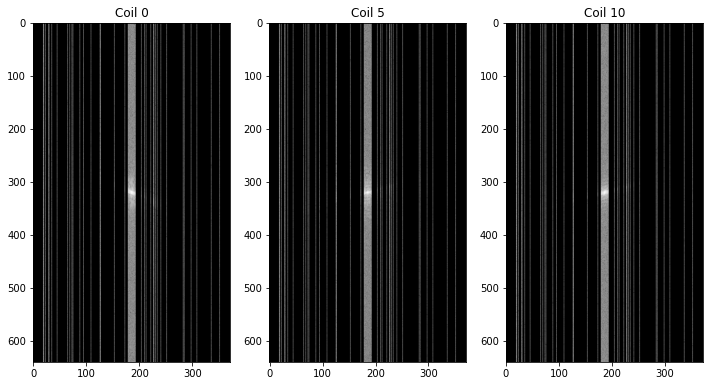

In [8]:
slice_kspace = volume_kspace[20]  

def show_coils(data, coil_nums, cmap=None):
    fig = plt.figure(figsize=(12,8))
    for i, num in enumerate(coil_nums):
        plt.subplot(1, len(coil_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.title(f"Coil {num}")

show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')  # This shows coils 0, 5 and 10
# Note: np.abs() on complex data is the same as calculating the magnitude. 1e-9 is added to avoid log(0).

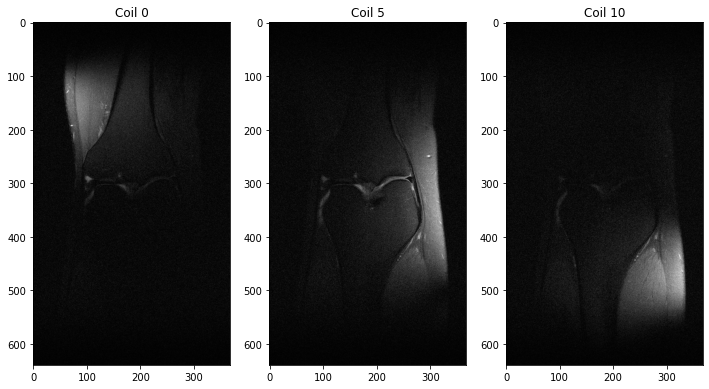

In [6]:
# reconstruction:
import fastmri
from fastmri.data import transforms as T

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

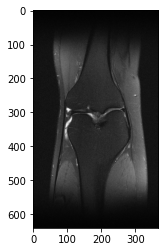

In [7]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

KSPACE AND RECONSTRUCTION OF UNDERSAMPLED DATA: (=input of our hybrid models)

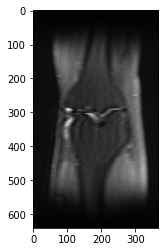

In [8]:
from fastmri.data.subsample import RandomMaskFunc
center_fractions = [0.08]
accelerations = [4]
mask_func = RandomMaskFunc(center_fractions, accelerations)  # Create the mask function object
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space


sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

VS RECONSTRUCTION OF CLASSICAL MODEL / HYBRID MODEL: